In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
def parse_csv_file(file_path):
    df = pd.read_csv(file_path)
    return df

def extract_last_values(df, bus_numbers, n_values=855):
    bus_data = {}
    for bus in bus_numbers:
        bus_data[bus] = df[[f'Bus{bus}', 'Label']].values[-n_values:]
    return bus_data


In [ ]:
def glr_cusum(data, mu0, sigma0, h):
    n = len(data)
    g = np.zeros(n)
    for k in range(1, n):
        max_val = -np.inf
        for j in range(1, k+1):
            local_sum = np.sum((data[j-1:k] - mu0)**2)
            quantity = local_sum / (k - j + 1)
            if quantity > max_val:
                max_val = quantity
        g[k] = (1 / (2 * sigma0**2)) * max_val
    return g

def calculate_median_and_mad(data):
    median = np.median(data)
    mad = np.median(np.abs(data - median)) * 1.4826  # 常数因子用于近似标准差
    return median, mad


In [ ]:
# 计算每个巴士的GLR统计量
def standardize_data(values):
    """ 标准化给定的numpy数组或Pandas序列 """
    mean = np.mean(values)
    std = np.std(values)
    standardized_values = (values - mean) / std
    return standardized_values
def calculate_glr_statistics(bus_data, best_thresholds):
    bus_statistics = {}
    for bus, data in bus_data.items():
        values = data[:, 0]
        labels = data[:, 1]
        h = best_thresholds[bus]
        # central_value, spread = calculate_median_and_mad(values)
        # g = glr_cusum(values, central_value, spread, h)
        scaler = StandardScaler()
        # standardized_values = scaler.fit_transform(values.reshape(-1, 1)).flatten()
        standardized_values = standardize_data(values)
        mu0, sigma0 = calculate_mu0_sigma0(standardized_values)
        g = glr_cusum(standardized_values, mu0, sigma0, h)


        # 找到第一个标签为1的索引
        attack_index = np.where(labels == 1)[0]
        first_attack_index = attack_index[0] if len(attack_index) > 0 else -1

        bus_statistics[bus] = (g, first_attack_index)
    return bus_statistics
def calculate_mu0_sigma0(data):
  mu0 = np.mean(data)
  sigma0 = np.std(data)
  return mu0, sigma0

# 读取数据
file_path = '/content/drive/MyDrive/ColabNotebooks/MSCProject/DataSet/LMPs/A_LMPFreq3_Labeled.csv'
df = parse_csv_file(file_path)

# 提取巴士数据
bus_numbers = [115, 116, 117, 118, 119, 121, 135, 139]
# bus_numbers = [115, 116, 117, 118, 119, 121,122,123,124,125,126,127,128,129,130,131,132,133,134, 135, 139]
bus_data = extract_last_values(df, bus_numbers)

In [ ]:
# 最佳阈值
best_thresholds = {115: 2.19, 116: 6.19, 117: 2.39, 118: 1.79, 119: 1.19, 121: 8.39, 135: 4.79, 139: 3}
# best_thresholds = {
#     115: 2.2,
#     116: 6.2,
#     117: 2.4,
#     118: 1.8,
#     119: 2.2,
#     121: 8.4,
#     122: 2.4,
#     123: 1.0,
#     124: 3.8,
#     125: 4.0,
#     126: 4.0,
#     127: 3.8,
#     128: 3.8,
#     129: 3.8,
#     130: 6.8,
#     131: 2.2,
#     132: 4.2,
#     133: 5.0,
#     134: 3.4,
#     135: 4.8,
#     139: 3.4
# }
# 计算每个巴士的 GLR 统计量

bus_statistics = calculate_glr_statistics(bus_data, best_thresholds)

# 全局阈值 H 的计算
H_values = {
    'mean': np.mean(list(best_thresholds.values())),
    'min': np.min(list(best_thresholds.values())),
    'max': np.max(list(best_thresholds.values())),
    'median': np.median(list(best_thresholds.values()))
}



In [ ]:
H_values['min'] = 1.6

In [ ]:
# 聚合函数：平均值聚合
def aggregate_statistics_mean(bus_statistics, H):
    total_steps = len(next(iter(bus_statistics.values()))[0])
    aggregated_values = np.zeros(total_steps)

    for t in range(total_steps):
        values_at_t = np.array([g[t] for g, _ in bus_statistics.values()])
        aggregated_values[t] = np.mean(values_at_t)

    detection_time = np.argmax(aggregated_values > H)
    print(aggregated_values[detection_time])
    print("===================")
    print(H)
    # if aggregated_values[detection_time] <= H:
    #     detection_time = -1
    return detection_time, aggregated_values

1.2538700668879028
1.19


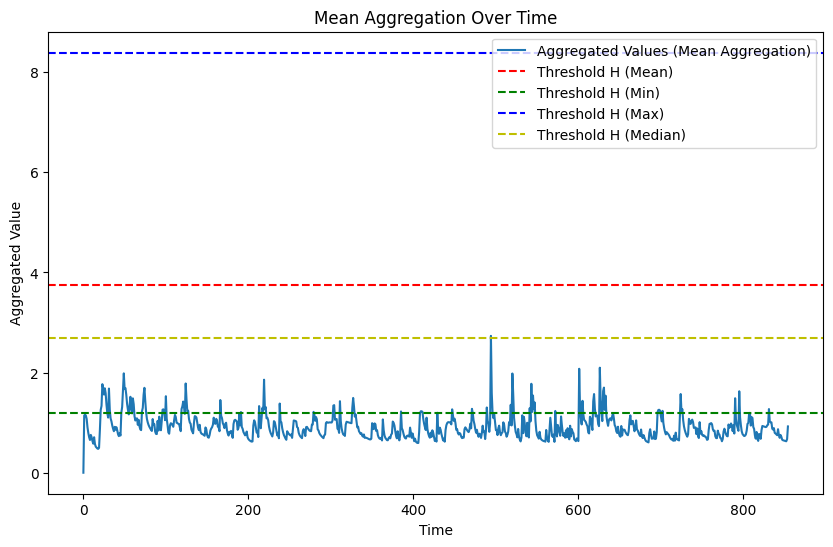

In [ ]:
detection_time, aggregated_values = aggregate_statistics_mean(bus_statistics, H_values['min'])
# 可视化 aggregated_values
plt.figure(figsize=(10, 6))
plt.plot(aggregated_values, label='Aggregated Values (Mean Aggregation)')
plt.axhline(y=H_values['mean'], color='r', linestyle='--', label='Threshold H (Mean)')
plt.axhline(y=H_values['min'], color='g', linestyle='--', label='Threshold H (Min)')
plt.axhline(y=H_values['max'], color='b', linestyle='--', label='Threshold H (Max)')
plt.axhline(y=H_values['median'], color='y', linestyle='--', label='Threshold H (Median)')
plt.xlabel('Time')
plt.ylabel('Aggregated Value')
plt.title('Mean Aggregation Over Time')
plt.legend()
plt.show()

In [ ]:
# 计算检测延迟
def calculate_detection_delay_mean(bus_data, bus_statistics, H_values):
    results = {}

    for H_name, H_value in H_values.items():
        detection_time, _ = aggregate_statistics_mean(bus_statistics, H_value)
        real_change_points = [first_attack_index for _, first_attack_index in bus_statistics.values()]
        first_real_change = min(real_change_points)
        # print(first_real_change)
        results[H_name] = detection_time
        # if detection_time != -1 and first_real_change != -1:
        #     delay = detection_time - first_real_change
        #     results[H_name] = delay if delay >= 0 else 'False Alarm'
        # else:
        #     results[H_name] = 'False Alarm'
    return results

In [ ]:
# 计算不同全局阈值下的检测延迟
detection_delays_mean = calculate_detection_delay_mean(bus_data, bus_statistics, H_values)
detection_delays_mean

0.0
3.74125
1.2538700668879028
1.19
0.0
8.39
2.7332464773258573
2.6950000000000003


{'mean': 0, 'min': 21, 'max': 0, 'median': 494}

In [ ]:
# 聚合函数：中位数聚合
def aggregate_statistics_median(bus_statistics, H):
    total_steps = len(next(iter(bus_statistics.values()))[0])
    aggregated_values = np.zeros(total_steps)

    for t in range(total_steps):
        values_at_t = np.array([g[t] for g, _ in bus_statistics.values()])
        aggregated_values[t] = np.median(values_at_t)

    detection_time = np.argmax(aggregated_values > H)
    print(detection_time)
    if aggregated_values[detection_time] <= H:
        detection_time = -1
    return detection_time, aggregated_values


In [ ]:
# 计算检测延迟
def calculate_detection_delay_median(bus_data, bus_statistics, H_values):
    results = {}

    for H_name, H_value in H_values.items():
        detection_time, _ = aggregate_statistics_median(bus_statistics, H_value)
        real_change_points = [first_attack_index for _, first_attack_index in bus_statistics.values()]
        first_real_change = min(real_change_points)
        if detection_time != -1 and first_real_change != -1:
            delay = detection_time - first_real_change
            results[H_name] = delay if delay >= 0 else 'False Alarm'
        else:
            results[H_name] = 'False Alarm'
    return results


494


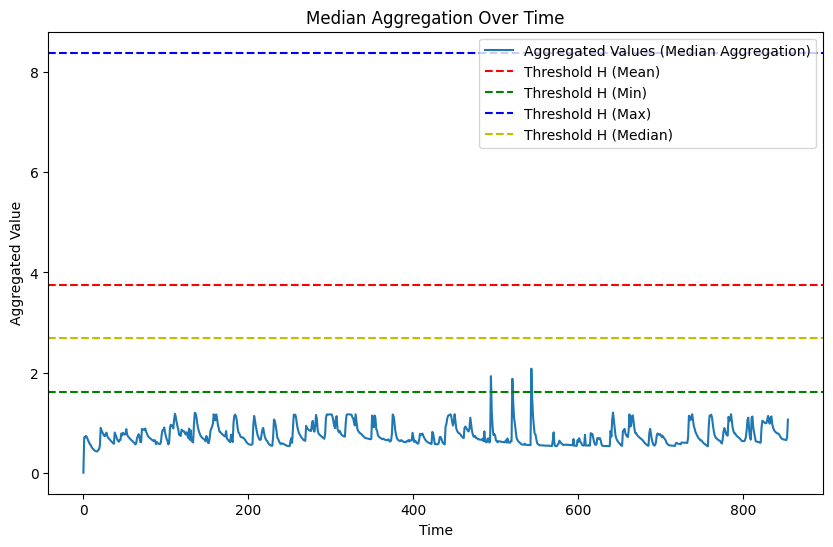

In [ ]:
detection_time, aggregated_values = aggregate_statistics_median(bus_statistics, H_values['min'])
H_values['min'] = 1.61
# 可视化 aggregated_values
plt.figure(figsize=(10, 6))
plt.plot(aggregated_values, label='Aggregated Values (Median Aggregation)')
plt.axhline(y=H_values['mean'], color='r', linestyle='--', label='Threshold H (Mean)')
plt.axhline(y=H_values['min'], color='g', linestyle='--', label='Threshold H (Min)')
plt.axhline(y=H_values['max'], color='b', linestyle='--', label='Threshold H (Max)')
plt.axhline(y=H_values['median'], color='y', linestyle='--', label='Threshold H (Median)')
plt.xlabel('Time')
plt.ylabel('Aggregated Value')
plt.title('Median Aggregation Over Time')
plt.legend()
plt.show()

In [ ]:

# 计算不同全局阈值下的检测延迟
detection_delays_median = calculate_detection_delay_median(bus_data, bus_statistics, H_values)

# 打印结果
for H_name, delay in detection_delays_median.items():
    print(f"Global threshold H = {H_name}: Detection Delay = {delay}")


0
494
0
0
Global threshold H = mean: Detection Delay = False Alarm
Global threshold H = min: Detection Delay = 24
Global threshold H = max: Detection Delay = False Alarm
Global threshold H = median: Detection Delay = False Alarm


In [ ]:
# 计算 MAD（中位数绝对偏差）
def mad(data, threshold=3.5):
    median = np.median(data)
    deviation = np.abs(data - median)
    mad_value = np.median(deviation)
    modified_z_score = 0.6745 * deviation / mad_value
    return data[modified_z_score < threshold]

# 聚合函数：异常值检测聚合
def aggregate_statistics_mad(bus_statistics, H):
    total_steps = len(next(iter(bus_statistics.values()))[0])
    aggregated_values = np.zeros(total_steps)

    for t in range(total_steps):
        values_at_t = np.array([g[t] for g, _ in bus_statistics.values()])
        filtered_values = mad(values_at_t)
        aggregated_values[t] = np.mean(filtered_values)

    detection_time = np.argmax(aggregated_values > H)
    print(detection_time)
    if aggregated_values[detection_time] <= H:
        detection_time = -1
    return detection_time, aggregated_values
detection_time, aggregated_values_1 = aggregate_statistics_mad(bus_statistics, H_values['median'])

0


<ipython-input-108-632f10613ae4>:6: RuntimeWarning: invalid value encountered in divide
  modified_z_score = 0.6745 * deviation / mad_value
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


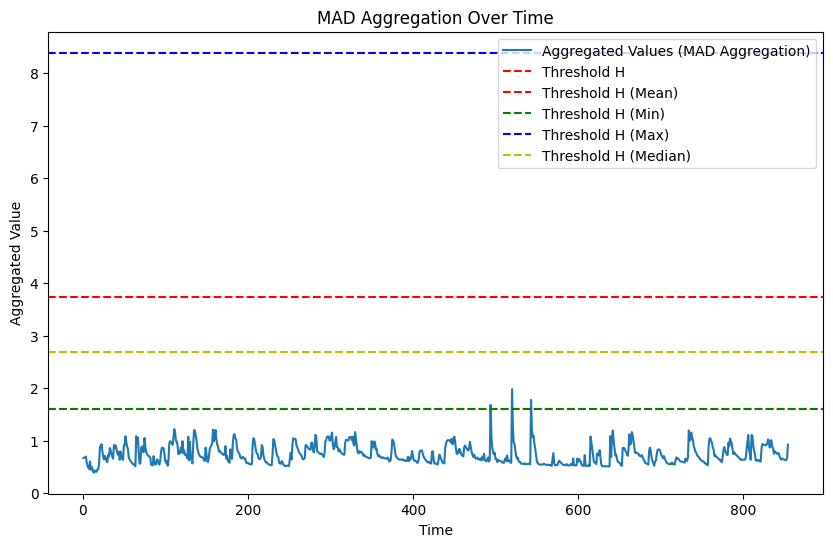

In [ ]:
# 可视化 aggregated_values
plt.figure(figsize=(10, 6))
plt.plot(aggregated_values_1, label='Aggregated Values (MAD Aggregation)')
plt.axhline(y=H_values['min'], color='r', linestyle='--', label='Threshold H')
plt.axhline(y=H_values['mean'], color='r', linestyle='--', label='Threshold H (Mean)')
plt.axhline(y=H_values['min'], color='g', linestyle='--', label='Threshold H (Min)')
plt.axhline(y=H_values['max'], color='b', linestyle='--', label='Threshold H (Max)')
plt.axhline(y=H_values['median'], color='y', linestyle='--', label='Threshold H (Median)')
plt.xlabel('Time')
plt.ylabel('Aggregated Value')
plt.title('MAD Aggregation Over Time')
plt.legend()
plt.show()

In [ ]:
# 计算检测延迟：异常值检测聚合
def calculate_detection_delay_mad(bus_data, bus_statistics, H_values):
    results = {}

    for H_name, H_value in H_values.items():
        detection_time, _ = aggregate_statistics_mad(bus_statistics, H_value)
        real_change_points = [first_attack_index for _, first_attack_index in bus_statistics.values()]
        # print(detection_time)
        first_real_change = min(real_change_points)
        if detection_time != -1 and first_real_change != -1:
            delay = detection_time - first_real_change
            results[H_name] = delay
        else:
            results[H_name] = 'False Alarm'
    return results
# 计算不同全局阈值下的检测延迟
detection_delays_mad = calculate_detection_delay_mad(bus_data, bus_statistics, H_values)

# 打印结果
for H_name, delay in detection_delays_mad.items():
    print(f"Global threshold H = {H_name}: Detection Delay = {delay}")

<ipython-input-108-632f10613ae4>:6: RuntimeWarning: invalid value encountered in divide
  modified_z_score = 0.6745 * deviation / mad_value


0
494
0
0
Global threshold H = mean: Detection Delay = -470
Global threshold H = min: Detection Delay = 24
Global threshold H = max: Detection Delay = -470
Global threshold H = median: Detection Delay = -470
